In [17]:
global ROOT_DIR
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'
global DATA_DIR
DATA_DIR = f'{ROOT_DIR}/data/ISIC'

In [19]:
sys.path.append(f'{ROOT_DIR}/code/ISIC/')
sys.path.append(f'{ROOT_DIR}/code/ISIC/vgg_ae')
sys.path.append(f'{ROOT_DIR}/code/helper/')
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
import json
from itertools import combinations
import OTCost as ot
import embedding as emb
import vgg
import dataset
import importlib
importlib.reload(ot)
importlib.reload(emb)
importlib.reload(dataset)
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader as dl
from sklearn.metrics.pairwise import cosine_similarity
from collections import OrderedDict

# EMBED IMAGES

In [2]:
BATCH_SIZE = 8

## Check losses (trained embedding)

In [30]:
with open(f'{ROOT_DIR}/data/ISIC/losses.json', 'r') as f:
        losses = json.load(f)

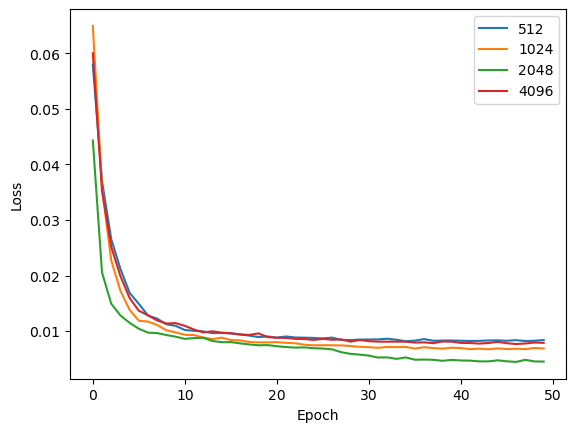

In [31]:
#Plot validation losses
for key, value in losses.items():
    label = key
    loss_list = value[0]
    plt.plot(loss_list, label=label)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Load model

In [34]:
## Trained myself
n_emb = 4096
model = emb.Autoencoder(n_emb)
checkpoint = torch.load(f'{DATA_DIR}/model_checkpoint_{n_emb}.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [203]:
## Pretrained
configs = vgg.get_configs('vgg16')
model = vgg.VGGAutoEncoder(configs)
checkpoint = torch.load(f'{ROOT_DIR}/code/ISIC/vgg_ae/imagenet-vgg16.pth', map_location=torch.device('cpu'))
new_state_dict = OrderedDict()
for key, value in checkpoint['state_dict'].items():
    if 'module.' in key:
        name = key[7:] # remove 'module.' prefix
    else:
         name = key 
    new_state_dict[name] = value
model.load_state_dict(new_state_dict)

<All keys matched successfully>

## Visualise data

In [204]:
train_data = dataset.FedIsic2019(train=True, pooled = True, data_path=DATA_DIR)
val_data = dataset.FedIsic2019(train=False, pooled = True, data_path=DATA_DIR)
train_loader = dl(train_data, batch_size = BATCH_SIZE, shuffle = True)
val_loader = dl(val_data, batch_size = BATCH_SIZE, shuffle = True)

In [25]:
def visualize(images, reconstructed_images):
    n = images.shape[0]
    for i in range(n):
        img1 = images[i, :, :, :].detach()
        img2 = reconstructed_images[i, :, :, :].detach()

        img1 = np.array(img1).transpose(1,2,0) * 255
        img1 = (img1).astype('uint8')

        img2 = np.array(img2).transpose(1,2,0) * 255
        img2 = (img2).astype('uint8')

        # Plotting the images
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img1)
        axes[0].set_title('True Image')
        axes[1].imshow(img2)
        axes[1].set_title('Reconstructed Image')

    plt.show()

In [205]:
image, _, _ = next(iter(train_loader))
image = image.transpose(2,1)

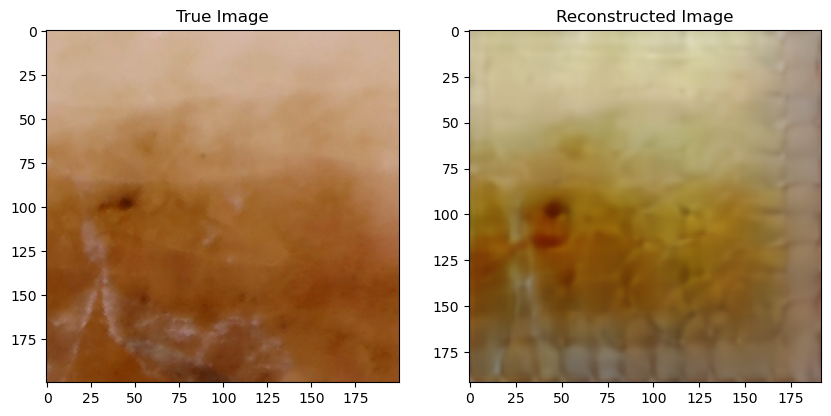

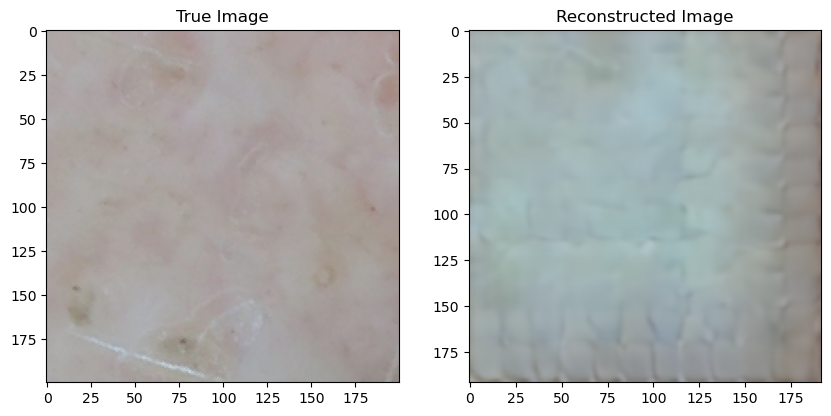

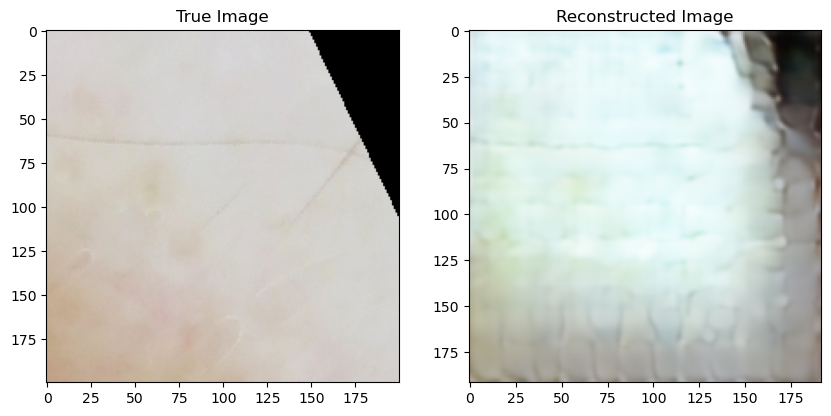

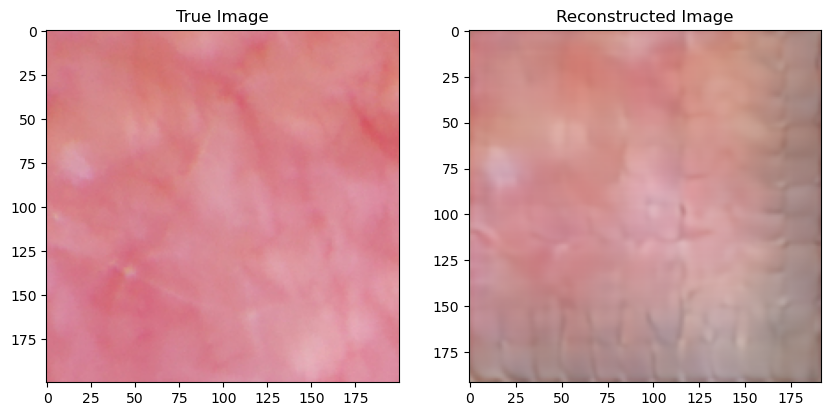

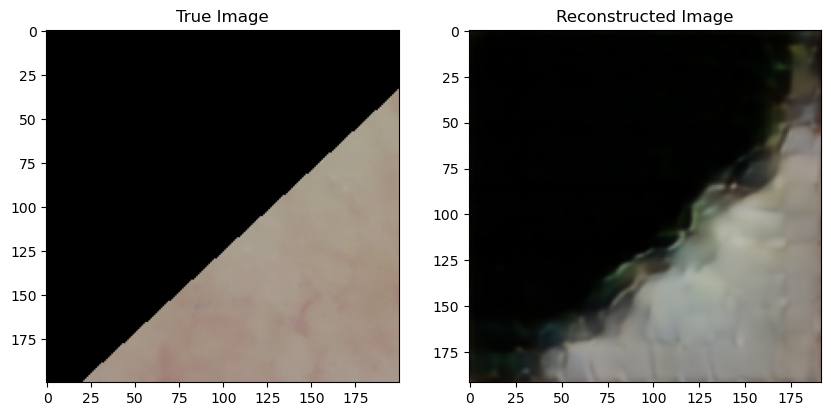

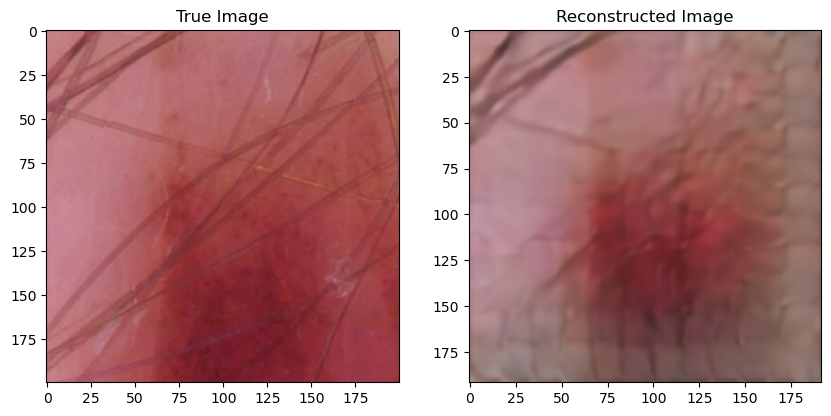

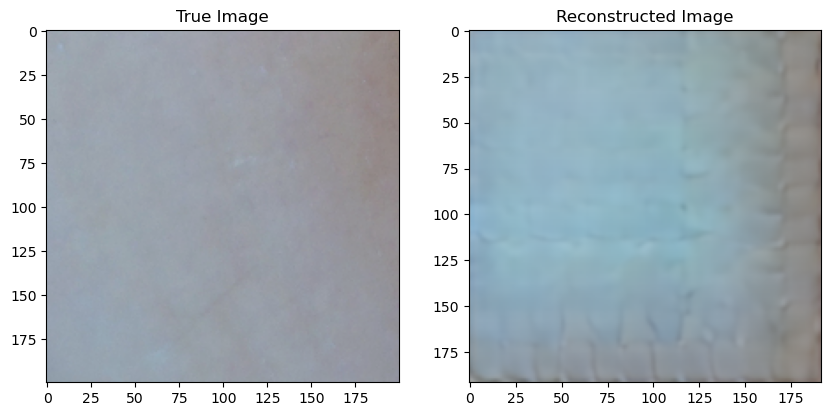

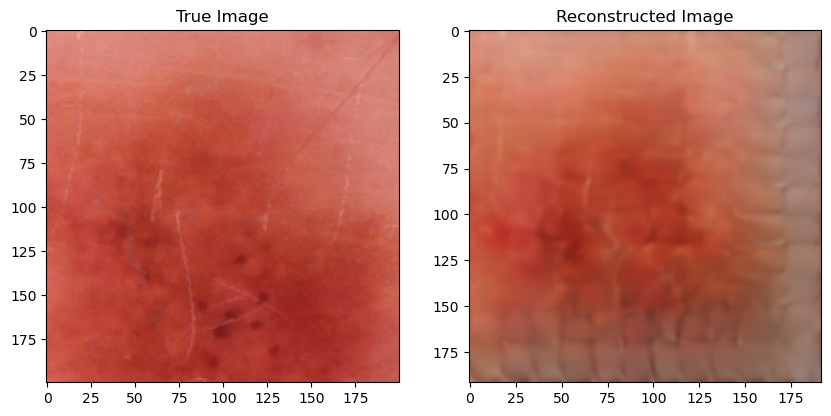

In [206]:
reconstructed = model(image)
visualize(image, reconstructed)

## Create embeddings

In [37]:
def extract_embedding(image):
    B = image.shape[0]
    with torch.no_grad():
        image = image.transpose(2,1)
        embedding = model(image, embedding = True)
        return embedding.reshape(B,-1).detach()

In [38]:
def create_embedding(loader, center):
    labels_list = []
    names_list = []
    count = 0
    for images, labels, paths in loader:
        embeddings = extract_embedding(images)
        image_names = [p.split('/')[-1].split('.')[0] for p in paths]
        names_list.extend(image_names)
        emb_paths = [f'{DATA_DIR}/embedding/center_{center}_{image_name}' for image_name in image_names]
        for i in range(len(emb_paths)):
            emb_save = embeddings[i].numpy()
            emb_path = emb_paths[i]
            np.save(emb_path, emb_save)
        labels_list.append(labels)   
    all_labels = (torch.cat(labels_list, dim=0)).numpy()
    labels_df = pd.DataFrame({
                    "Name": names_list,
                    "Label": all_labels
                })
    labels_df.to_csv(f'{DATA_DIR}/center_{center}_labels.csv', index = False)
    return

In [139]:
sites_loaders = {}
for i in range(6):
    train_data = dataset.FedIsic2019(center = i, train=True, pooled = False, data_path=DATA_DIR)
    val_data = dataset.FedIsic2019(center = i, train=False, pooled = False, data_path=DATA_DIR)
    train_loader = dl(train_data, batch_size = BATCH_SIZE, shuffle = False)
    val_loader = dl(val_data, batch_size = BATCH_SIZE, shuffle = False)
    sites_loaders[i]= (train_loader, val_loader)

In [ ]:
for i in range(1,6):
    train_loader, val_loader = sites_loaders[i]
    create_embedding(train_loader, center = i)
    #create_embedding(val_loader, center = i)

# Create embedding datasets to calculate cost

In [200]:
##Load labels
labels = pd.read_csv(f'{DATA_DIR}/ISIC_2019_Training_GroundTruth.csv')
def create_category(row):
    for idx, value in enumerate(row):
        if value == 1:
            return idx
    return None

labels['label'] = labels.apply(create_category, axis=1) - 1
labels = labels[['image', 'label']]
labels.set_index('image', inplace = True)

In [202]:
NUM_SAMPLES = 2000
files = os.listdir(f'{DATA_DIR}/embedding')
sites = [i for i in range(6)]
site_samples = {}
site_embeddings = {}
site_labels = {}
for site in sites:
    sites_files = [file for file in files if f'center_{site}' in file]
    sites_files = np.random.choice(sites_files, size = NUM_SAMPLES)
    site_samples[site] = sites_files
    names = [f.split(f'center_{site}_')[-1].split('.npy')[0] for f in sites_files]
    labels_site = labels.loc[names]
    site_labels[site] = labels_site['label'].values
    labels_site.to_csv(f'{DATA_DIR}/site_{site}_files_used.csv')

for site, files in site_samples.items():
    embeddings = [np.load(f'{DATA_DIR}/embedding/{file}') for file in files]
    site_embeddings[site] = np.array(embeddings)

# Measure OT cost

In [185]:
def create_dictionaries(site_embeddings, site_labels, sites, NUM_SAMPLES = 500):
    data = {'1': site_embeddings[sites[0]][:NUM_SAMPLES], '2' :site_embeddings[sites[1]][:NUM_SAMPLES]}
    labels = {'1': site_labels[sites[0]][:NUM_SAMPLES], '2': site_labels[sites[1]][:NUM_SAMPLES]}
    data, labels = remove_rare_labels(data, labels, min_count = 30)
    return data, labels

#Function is needed as estimating label cost with fewer data points leads to degeneracy
def remove_rare_labels(data, labels, min_count):
    for key in labels:
        unique_labels, counts = np.unique(labels[key], return_counts=True)
        labels_to_remove = unique_labels[counts <= min_count]
        mask = np.isin(labels[key], labels_to_remove, invert=True)
        labels[key] = labels[key][mask]
        data[key] = data[key][mask]
    return data, labels


In [186]:
DATASET = 'ISIC'
NUM_SAMPLES = 500

In [ ]:
importlib.reload(ot)
sites = [i for i in range(6)]
site_pairs = list(combinations(sites, r = 2))
results = {}
#Between site cost calculation
for pair in site_pairs:
    data, labels = create_dictionaries(site_embeddings, site_labels, pair, NUM_SAMPLES)
    ISIC_OTCost_label = ot.OTCost(DATASET, data, labels)
    cost = ISIC_OTCost_label.calculate_ot_cost()
    results[pair] = cost

#Same site cost calculation
for site in range(6):
    data = {'1': site_embeddings[site][:NUM_SAMPLES], '2' :site_embeddings[site][NUM_SAMPLES:NUM_SAMPLES*2]}
    labels = {'1': site_labels[site][:NUM_SAMPLES], '2': site_labels[site][NUM_SAMPLES:NUM_SAMPLES*2]}
    data, labels = remove_rare_labels(data, labels, min_count = 30)
    ISIC_OTCost_label = ot.OTCost(DATASET, data, labels)
    cost = ISIC_OTCost_label.calculate_ot_cost()
    results[(site, site)] = cost


np.set_printoptions(formatter={'float': lambda x: "{:.2f}".format(x)})

In [194]:
results_df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['Cost'])
results_df.reset_index(inplace=True)
results_df['Site_1'], results_df['Site_2'] = zip(*results_df['index'])
results_df = results_df.drop(columns='index')
results_df['Cost']  = pd.to_numeric(results_df['Cost'])
results_df.to_csv(f'{ROOT_DIR}/results/ISIC/dataset_ot_costs.csv', index = False)


In [207]:
n = 6
matrix = np.zeros((n, n))
for _, row in results_df.iterrows():
    cost = row['Cost']
    s1 = int(row['Site_1'])
    s2 = int(row['Site_2'])
    matrix[s1, s2] = cost
    matrix[s2, s1] = cost
print(matrix)

[[0.08 0.20 0.15 0.16 0.16 0.20]
 [0.20 0.08 0.25 0.30 0.28 0.17]
 [0.15 0.25 0.06 0.19 0.16 0.21]
 [0.16 0.30 0.19 0.06 0.19 0.26]
 [0.16 0.28 0.16 0.19 0.08 0.23]
 [0.20 0.17 0.21 0.26 0.23 0.08]]


In [197]:
matrix = pd.DataFrame(matrix)
matrix.to_csv(f'{ROOT_DIR}/results/ISIC/dataset_ot_costs_matrix.csv')